The goal for this lesson is to carry out SINDy on some synthetic data.

## Background
SINDy is a method for inferring differential equations from data. To fix notation, we briefly review SINDy here:

Suppose $\textbf{x}\in \mathbb{R}^{N_t \times n}$ is a multi-variable time series that we've either measured or simulated somehow. The first index corresponds to time, and the second index corresponds to the different variables we've measured. Using some means of numerical differentiation such as finite difference (could also consider e.g. spectral differentiation), we obtain an estimate of derivative of $\textbf{x}$ with respect to time, which we call $\dot{\textbf{x}}\in \mathbb{R}^{N_t \times n}$.

We suppose that $\dot{{\bf x}}$ can be expressed as a function of ${\bf x}$: $\dot{{\bf x}} = {\bf f}({\bf x})$. We further suppose that ${\bf f}$ can be written as a linear combination of certain scalar-valued basis functions:

$$
\dot{{\bf x}} = {\bf f}({\bf x}) = \sum_{j=1}^{m} {\bf \xi_j} \theta_j({\bf x})
$$

**Pause**. What is the dimension of each mathematical object in the above expression?

This can be written in matrix form:

$$
\begin{align}
\dot{{\bf x}} &= 
\begin{bmatrix}
\vert & \vert & \vert \\
\theta_1({\bf x}) & \dots & \theta_m({\bf x})\\
\vert & \vert & \vert \\
\end{bmatrix}
\begin{bmatrix}
\xi_1\\
\vdots \\
\xi_m\\
\end{bmatrix}\\
\dot{{\bf x}} &= \Theta({\bf x}) \Xi
\end{align}
$$

The matrix $\Theta({\bf x})$ is a matrix whose columns are the candidate model terms, evaluated on the trajectory ${\bf x}$, and $\Xi$ is the matrix of unknown coefficients of the model terms. The SINDy method is to find a *sparse* solution $\Xi$ to the above equation

**Pause**. What is the dimension of each mathematical object in the above expression?

## Exercise
To start, we will use some data from the chaotic Lorenz system, which is shown below. In this case, we know the answer that SINDy should arrive at, so we can check our work and make sure that the method is working correctly.

In [1]:
# generate some data; the code below generates data from the Lorenz system
# the trajectory is generated below as X, a 2d array of shape (len(t), 3)
# note that this shape is the transpose of what is output from solve_ivp

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

dt = 0.01
T = 50
t = np.arange(dt,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28

def lorenz_rhs(t, x_y_z, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

y0 = (-8,8,27)
X = sp.integrate.solve_ivp(lorenz_rhs, (t.min(), t.max()), y0, t_eval = t).y.T # note the transpose!

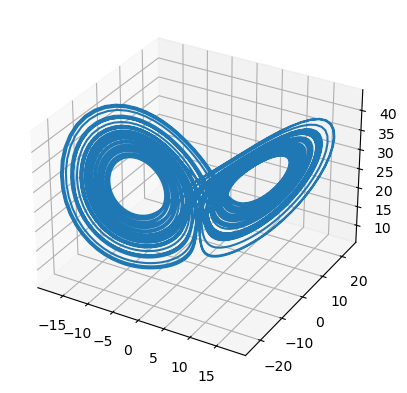

In [2]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2])

For our purposes, we now consider the matrix `X` to be data, from which we would like to the recover the ODE that generated it, i.e. the Lorenz equations.

To do this, we should first estimate $dx/dt$, the time derivative. We do this using the centered difference approximation that we derived earlier in the semester.

In [3]:
def centered_difference_derivative(X, dt):
    dXdt = np.zeros_like(X)
    ## code you wrote before...
    return dXdt

dXdt = centered_difference_derivative(X, dt)

Next, we need to compute the matrix $\Theta({\bf x})$, which relies on choosing a set of basis functions $\theta_j({\bf x})$. In this case, we will choose monomials, because the true right-hand side function for the Lorenz system truly is a linear combination of monomial terms. This is very similar to what you did before in one variable, but it's now more complicated because there are three varaibles instead of one.

One important thing is to keep track of which column corresponds to which monomial. For this purpose, I've suggested that your function should output a matrix that specifies the powers that define each monomial in your dictionary. You can feel free to do something else; for example, in Brunton's examples he maintains a list of string representations of the monomials, such as `'xy'` for $xy$ or `'xxy'` for $x^2 y$. Keeping track of the meaning of each column is important for interpreting the $\Xi$ matrix in the end.

In [9]:
def monomial_dictionary(X, maxdegree = 2):
    """
    Function to create a matrix whose columns are monomial functions of the system state X
    Should have one column for each monomial of degree not greater than maxdegree
    The degree of a monomial is the sum of the powers of each variable
        Examples:
            x^2 is of degree 2
            xy is of degree 2
            xyz is of degree 3
            x^2 y is of degree 3

    INPUT:
        X : (Nt, n) array giving the trajectory in question
            first index corresponds to time
            second index corresponds to the state space coordinate (e.g. x vs y vs z)
        maxdegree : integer (default = 2), the largest degree of a monomial to include in the library

    OUTPUT:
        Theta : (Nt, m) array giving values of the dictionary of candidate model terms
            first index corresponds to time
            second index corresponds to which monomial
        powers : (m, n) array giving the powers that define each monomial
            the m-th monomial will be x[0]**powers[m,0] * x[1]**powers[m,1] * ... * x[n-1]**powers[m,n-1]

    hint: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
    """
    from sklearn.preprocessing import PolynomialFeatures
    return None, None

In [10]:
Theta, powers = monomial_dictionary(X)

Now we need to evaluate the monomial dictionary on the computed trajectory, and find a sparse solution to the least squares problem.

There are many possible methods to find a sparse solution to the least squares problem. For example, you can use the LASSO method that we discussed before. You can also try "sequentially thresholded least squares" (STLS) as described in the book. The code cell below is identical to the book's Code 7.4 [Python] with a docstring added.

As you try out STLS, think about what the algorithm is doing and why it works the way it does. On what basis should you choose the threshold parameter $\lambda$? How does the algorithm's output change if you adjust it? What happens if you replace one of your model terms $\theta_i({\bf x})$ by $10^6 \theta_i({\bf x})$?

In [12]:
def sparsifyDynamics(Theta,dXdt,lamb,n):
    """
    Carries out the sequentially thresholded least squares algorithm

    INPUT:
        Theta : (Nt, m) array giving the values of the dictionary of candidate model terms
            first index corresponds to time
            second index corresponds to model term
        dXdt : (Nt, n) array giving the time derivative of the state variables
            first index corresponds to time
            second index corresponds to state variable
        lamb : scalar, cutoff value for small indices
        n : integer, number of state variables. equal to dXdt.shape[1].

    OUTPUT:
        Xi : (m, n) array of fitted coefficient values
            first index corresponds to the model term
            second index corresponds to the state dimension
            Xi[i, j] is the coefficient of model term i in the equation for d x_j / dt
    """
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares
    
    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]
    return Xi

In [20]:
Xi = sparsifyDynamics(Theta, dXdt, 0.1, 3)
Xi

array([[ 0.        ,  0.        ,  0.        ],
       [-9.98128608, 27.6240449 ,  0.        ],
       [ 9.98141986, -0.92086528,  0.        ],
       [ 0.        ,  0.        , -2.65912086],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99625984],
       [ 0.        , -0.98849203,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

Does this result make sense? How can you translate this back into an equation?

# Explore!

Try out SINDy on other trajectories. Try simulating a different differential equation and seeing if you can learn it. What happens if you try to learn the equation for a harmonic oscillator?

What are the limitations of SINDy? Can you use it to learn $\omega$ in $\dot{x} = \sin(\omega x)$? Can you use it to learn $k$ in $\dot{x} = 1/(1+kx)$?